In [55]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Input, Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt

# 1. 定义预处理函数
def preprocess_function(img):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)  # VGG16 需要 3 个通道的输入
    return img

# 2. 加载和预处理数据
data_dir = '../data/raw'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=preprocess_function  # 添加预处理函数
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 247 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


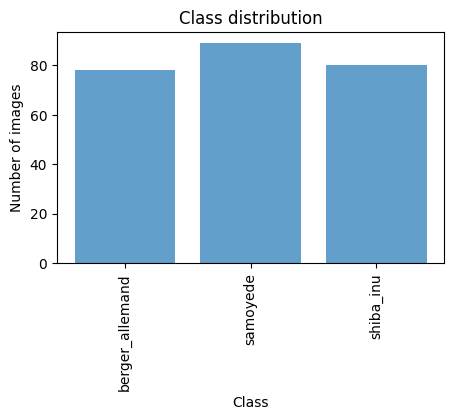

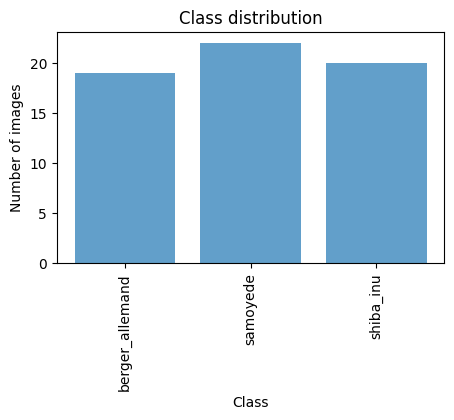

In [56]:
def plot_class_distribution(generator):
    class_counts = np.bincount(generator.classes)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(5, 3))
    plt.bar(class_labels, class_counts, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution')
    plt.xticks(rotation=90)
    plt.show()

# 可视化训练集类别分布
plot_class_distribution(train_generator)

# 可视化验证集类别分布
plot_class_distribution(validation_generator)


In [57]:
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense

# 构建模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 冻结预训练模型的层
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 添加早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 训练模型
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10


/Users/xinleichen/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.3336 - loss: 6.9954 - val_accuracy: 0.3607 - val_loss: 2.9246
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4653 - loss: 1.8838 - val_accuracy: 0.5082 - val_loss: 1.3783
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6342 - loss: 0.9746 - val_accuracy: 0.5574 - val_loss: 0.8786
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8196 - loss: 0.4818 - val_accuracy: 0.5902 - val_loss: 0.9304
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9222 - loss: 0.3254 - val_accuracy: 0.7049 - val_loss: 0.6838
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9749 - loss: 0.1902 - val_accuracy: 0.6885 - val_loss: 0.7298
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9986 - loss: 0.1477 - val_accuracy: 0.6557 - val_loss: 0.7016
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9991 - loss: 0.1099 - val_accuracy: 0.7049 - val_loss: 0.6803
Epoch 9/10
8/8 ━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report:
                  precision    recall  f1-score   support

berger_allemand       0.45      0.47      0.46        19
       samoyede       0.50      0.45      0.48        22
      shiba_inu       0.43      0.45      0.44        20

       accuracy                           0.46        61
      macro avg       0.46      0.46      0.46        61
   weighted avg       0.46      0.46      0.46        61

Confusion Matrix:
 [[ 9  5  5]
 [ 5 10  7]
 [ 6  5  9]]
Saved Classification Report:
                  precision    recall  f1-score   support

berger_allemand       0.45      0.47      0.46        19
       samoyede       0.50      0.45      0.48        22
      shiba_inu       0.43      0.45      0.44        20

       accuracy                           0.46        61
      macro avg       0.46      0.46      0.46        61
   weighted avg       0.46      0.46      0.46        61

Saved Confusion Matrix:
 [[ 9  5  5]
 [ 5 10  7]
 

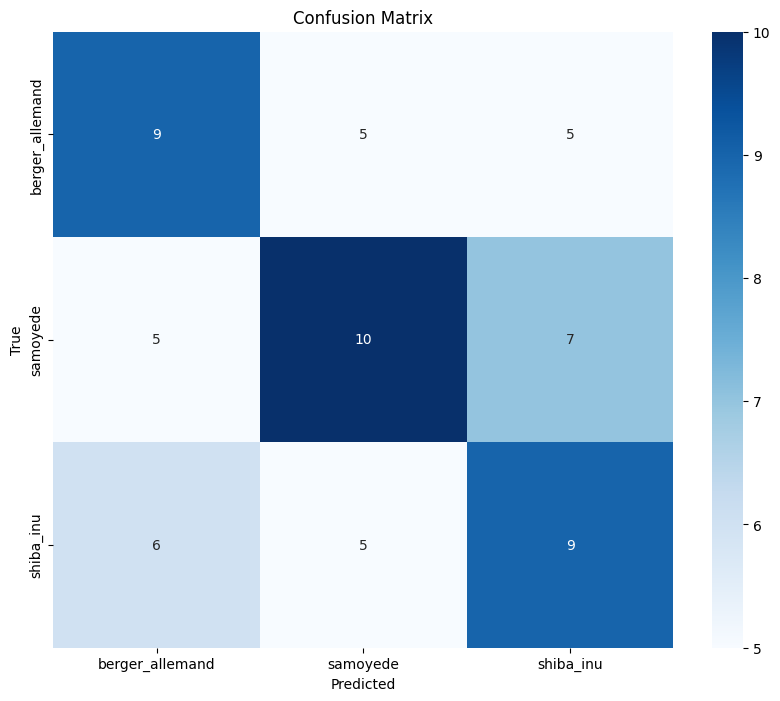

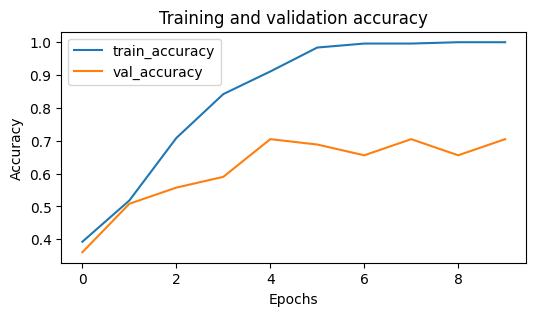

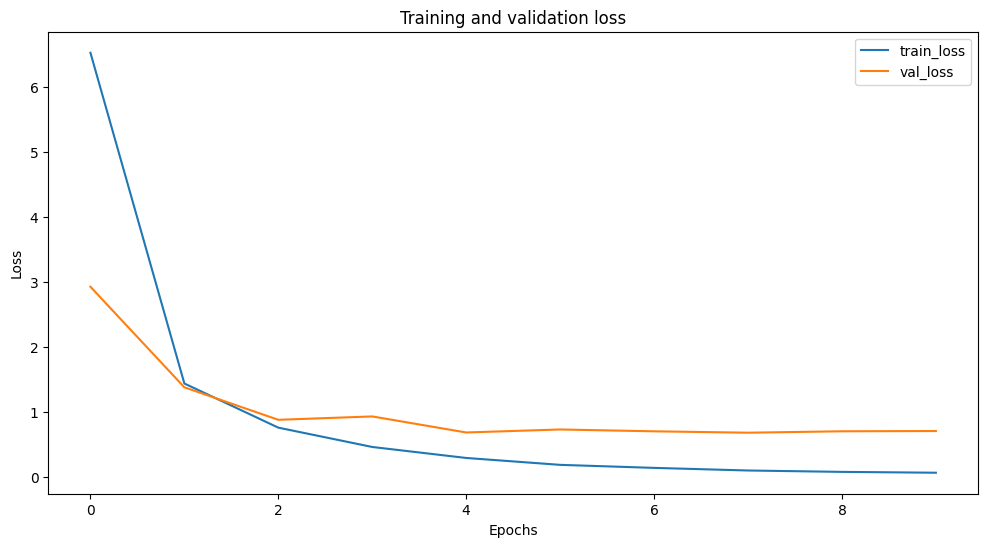

In [58]:
# 评估模型
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# 计算分类报告和混淆矩阵
report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
matrix = confusion_matrix(y_true, y_pred)

# 输出分类报告和混淆矩阵
print("Classification Report:\n", report)
print("Confusion Matrix:\n", matrix)

# 保存结果到文件
with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump({'report': report, 'matrix': matrix}, f)

# 读取结果并输出
with open('evaluation_results.pkl', 'rb') as f:
    results = pickle.load(f)
    print("Saved Classification Report:\n", results['report'])
    print("Saved Confusion Matrix:\n", results['matrix'])

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_labels = list(validation_generator.class_indices.keys())
plot_confusion_matrix(matrix, class_labels)

# 可视化训练过程
def plot_training_history(history):
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)